In [1]:
import datetime
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

In [2]:
import scanpy as sc
sc.logging.print_memory_usage()
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi = 300, dpi_save = 300)
sc.logging.print_header()

from matplotlib.pyplot import rc_context

Memory usage: current 0.22 GB, difference +0.22 GB
scanpy==1.10.2 anndata==0.10.8 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.0.3 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
# add the utility functions folder to PATH
sys.path.append(os.path.abspath("../packages"))
from db_dev.helper import *

In [4]:
import matplotlib as mpl
mpl.rc("font", family = "Arial")
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42


In [5]:
#home_dir = os.path.expanduser("~")
current_directory = os.getcwd()
adata = sc.read_h5ad(current_directory+"/backups/facs1_leiden_2.5_sub_annotation_25260x37733_250217_21h46.h5ad")

In [8]:
cell_type_color_palette_simplified = {
    "Monocytes/Myelomonocytes": "#2041c7", 
    "T cells": "#1b544c", 
    "B cells": "#f2836f",
    "NK cells": "#3bad48", 
    "Mature Neutrophils": "#532b6b", 
    "Basophils": "#2d4173",
    "Immature Neutrophils": "#9846a8",
    "Dendritic cells": "#602ab0",
    "AML cells": "#73472a",
    "Cycling AML cells": "#bf4a2e",


}

In [13]:
# Recode
renamer_sample = {
    "2-FM02-NP0000014": "AML2",
    "5-FM02-NP0000029": "AML4",
    "2-FM02-NP0000041": "AML6",
    "2-FM02-NP0000045": "AML7",
}
adata.obs["code_renamed"] = [renamer_sample[i] for i in adata.obs["code"]]


In [10]:
# Fold Enrichment Between Positive and Negative Fractions

import numpy as np
import pandas as pd

df = adata.obs.copy()

ct = pd.crosstab(df['cell_type'], df['facs'])

print("Contingency table:")
print(ct)

total_positive = ct['positive'].sum()
total_negative = ct['negative'].sum()
total = ct['total'] = ct['positive'] + ct['negative']

ct['prop_positive'] = ct['positive'] / total_positive
ct['prop_negative'] = ct['negative'] / total_negative

ct['enrichment'] = ct['prop_positive'] / ct['prop_negative']
ct['log2_enrichment'] = np.log2(ct['enrichment'])

ct['fold_change'] = ct['enrichment'].apply(lambda x: x if x >= 1 else -1/x)

enrichment_df = ct.reset_index()

enrichment_df.to_excel("enrichment/enrichment_ratio_v2.xlsx")

print("\nEnrichment dataframe with fold change:")
enrichment_df


Contingency table:
facs                      negative  positive
cell_type                                   
AML cells                     2205      4999
B cells                        275        38
Basophils                      157        39
Cycling AML cells             1034      1010
Immature Neutrophils           393        58
Mature Neutrophils            1045        78
Monocytes/Myelomonocytes      3876      7897
NK cells                       613        79
T cells                       1222       242

Enrichment dataframe with fold change:


facs,cell_type,negative,positive,total,prop_positive,prop_negative,enrichment,log2_enrichment,fold_change
0,AML cells,2205,4999,7204,0.346191,0.203789,1.698770,0.764491,1.698770
1,B cells,275,38,313,0.002632,0.025416,0.103541,-3.271731,-9.658041
2,Basophils,157,39,196,0.002701,0.014510,0.186134,-2.425589,-5.372482
3,Cycling AML cells,1034,1010,2044,0.069945,0.095564,0.731915,-0.450251,-1.366278
4,Immature Neutrophils,393,58,451,0.004017,0.036322,0.110585,-3.176775,-9.042833
5,Mature Neutrophils,1045,78,1123,0.005402,0.096580,0.055929,-4.160255,-17.879757
6,Monocytes/Myelomonocytes,3876,7897,11773,0.546884,0.358226,1.526646,0.610366,1.526646
7,NK cells,613,79,692,0.005471,0.056654,0.096567,-3.372333,-10.355553
8,T cells,1222,242,1464,0.016759,0.112939,0.148390,-2.752536,-6.739005


In [26]:
# For each patient

import numpy as np
import pandas as pd

pseudo_count = 1

patients = ["AML2", "AML4", "AML6", "AML7"]

for patient in patients:

    df = adata.obs.copy()

    df = df[df["code_renamed"] == patient].copy()

    ct = pd.crosstab(df['cell_type'], df['facs'])
    
    print("Contingency table:")
    print(ct)

    ct['positive'] = ct['positive'] + pseudo_count
    ct['negative'] = ct['negative'] + pseudo_count
    
    total_positive = ct['positive'].sum()
    total_negative = ct['negative'].sum()
    total = ct['total'] = ct['positive'] + ct['negative']
    
    ct['prop_positive'] = ct['positive'] / total_positive
    ct['prop_negative'] = ct['negative'] / total_negative
    
    ct['enrichment'] = (ct['prop_positive'] / ct['prop_negative'])
    
    ct['log2_enrichment'] = np.log2(ct['enrichment'])
    
    ct['fold_change'] = ct['enrichment'].apply(lambda x: x if x >= 1 else (-np.inf if x == 0 else -1/x))

    enrichment_df = ct.reset_index()
    
    enrichment_df.to_excel(f"enrichment/enrichment_ratio_{patient}_pseudocount.xlsx")



Contingency table:
facs                      negative  positive
cell_type                                   
AML cells                     1380      1797
B cells                          4         0
Basophils                       86        12
Cycling AML cells              238        96
Immature Neutrophils             1         1
Mature Neutrophils              11         1
Monocytes/Myelomonocytes        53        22
NK cells                         4         3
T cells                         28         2
Contingency table:
facs                      negative  positive
cell_type                                   
AML cells                      403      1712
B cells                        181        25
Basophils                        2        14
Cycling AML cells               69       113
Immature Neutrophils            16         1
Mature Neutrophils              84         5
Monocytes/Myelomonocytes       679       512
NK cells                       404        52
T cells          

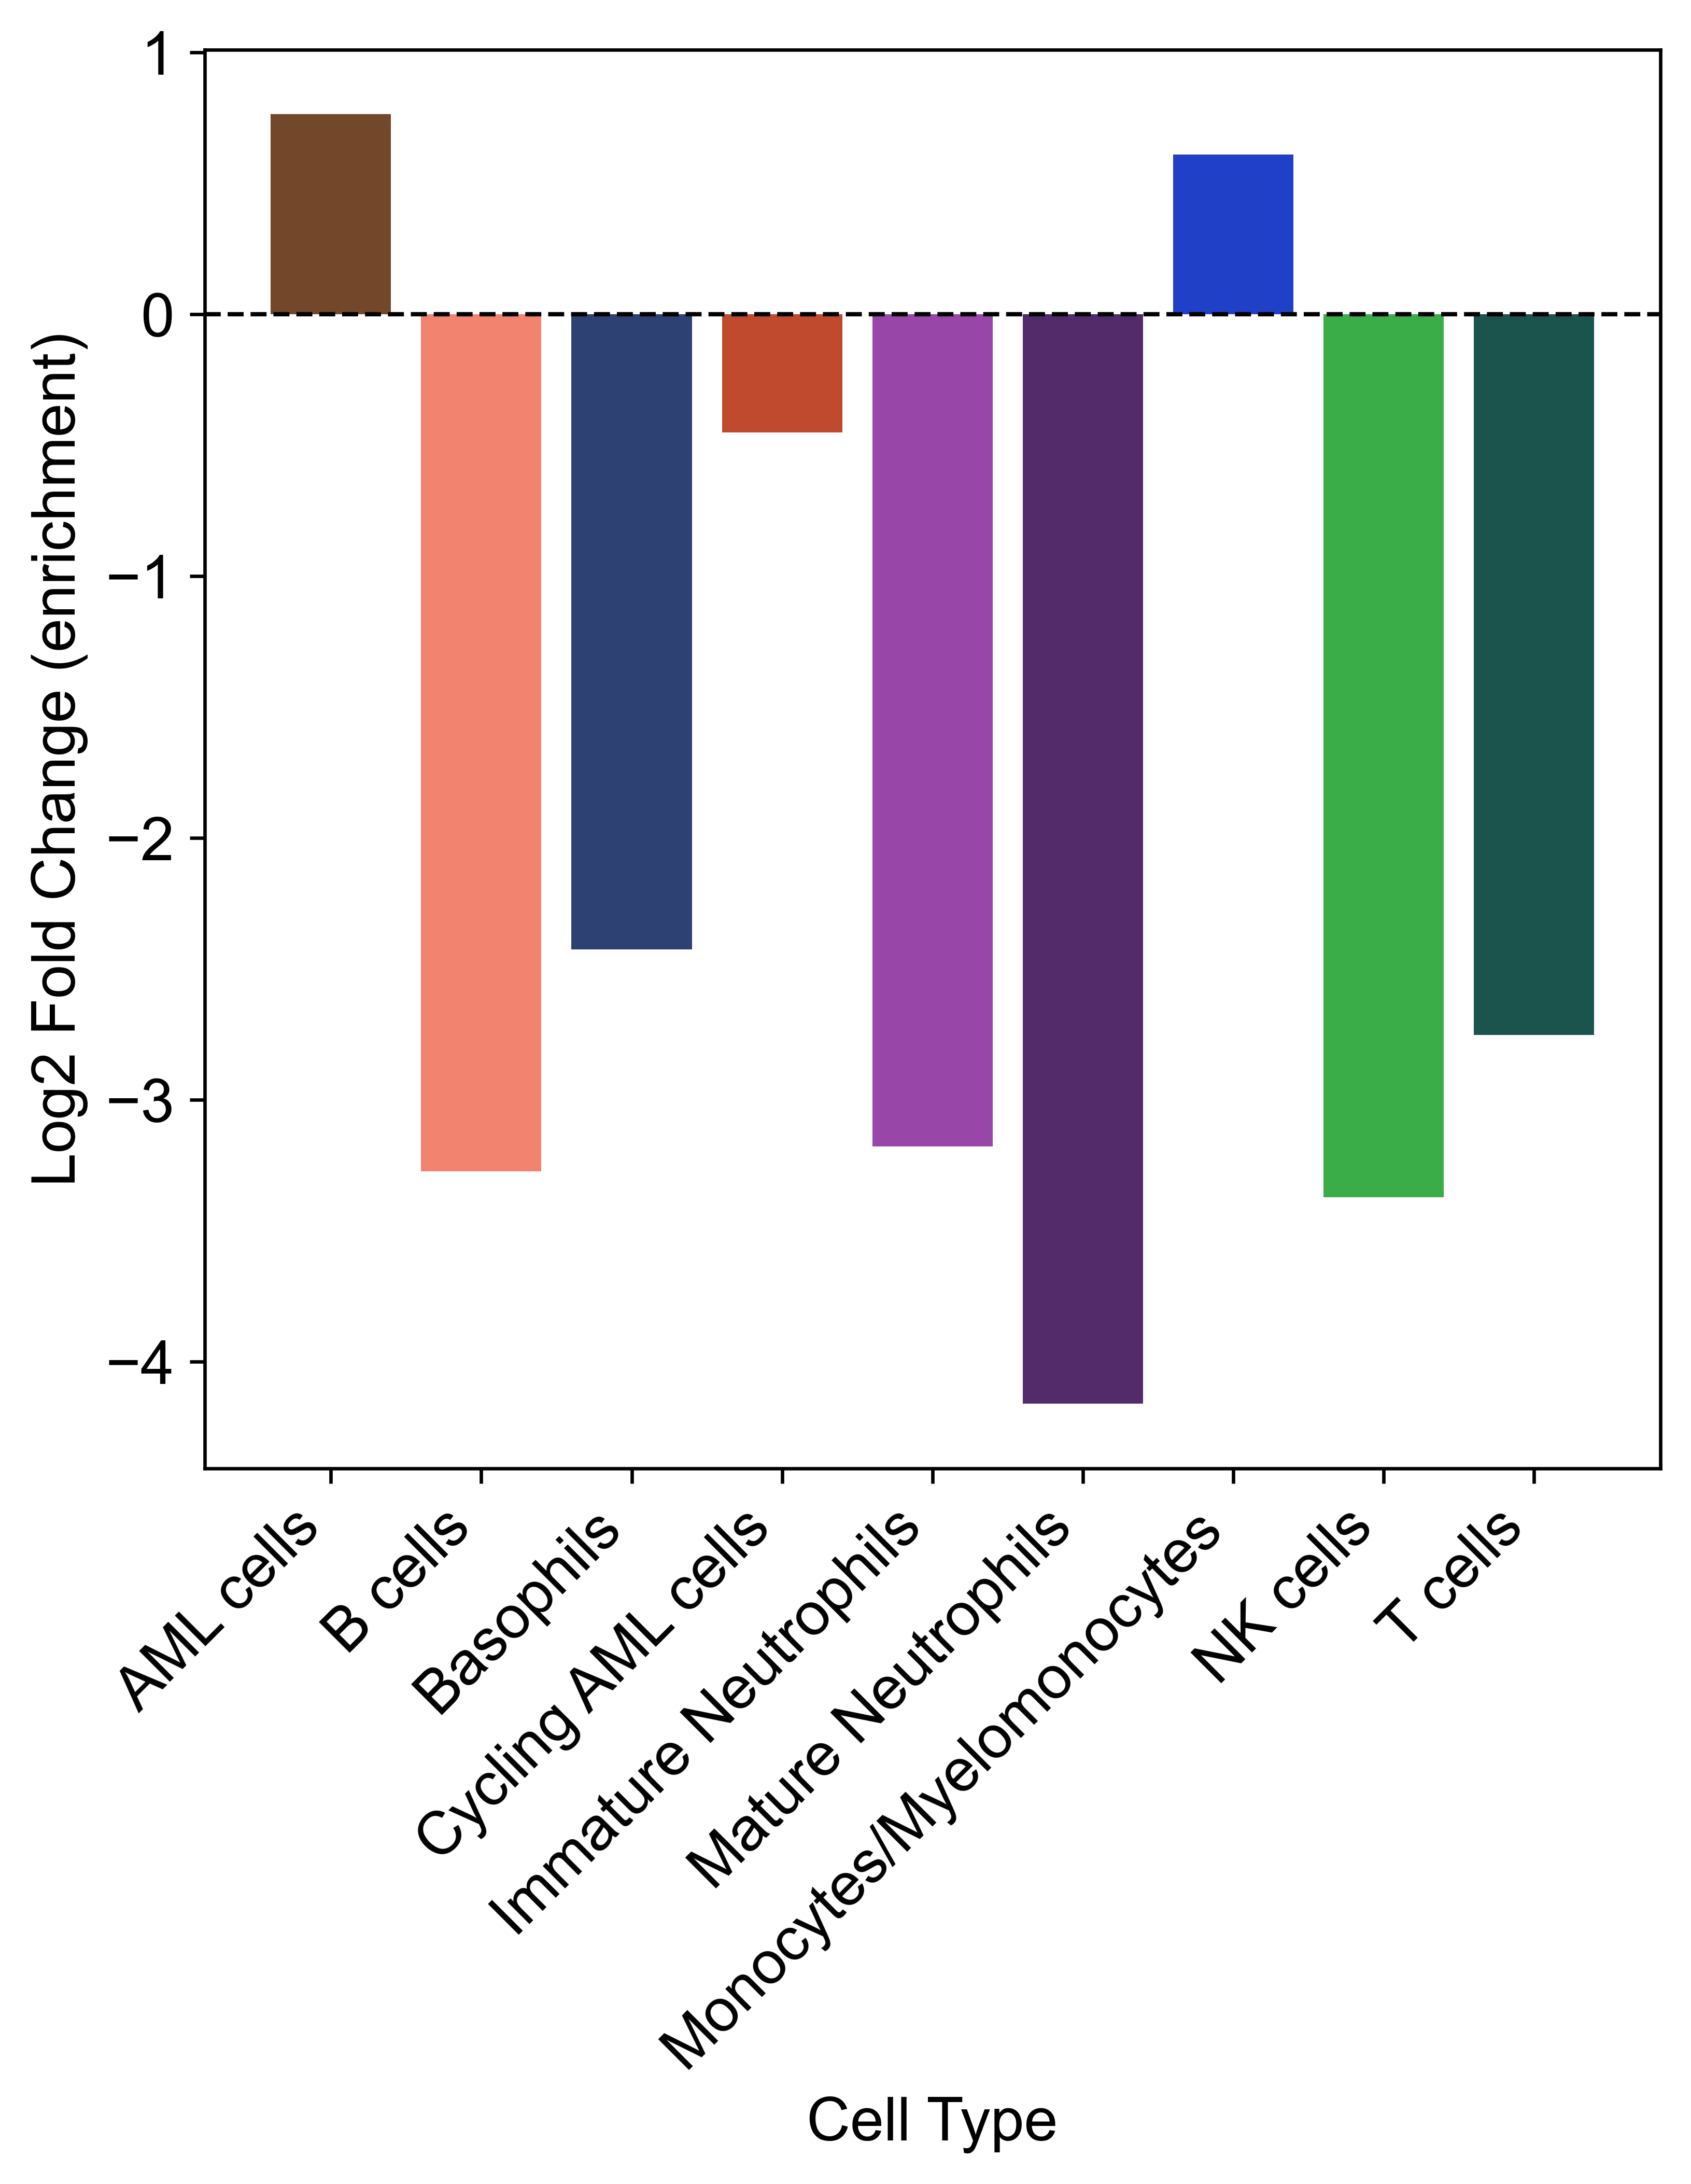

In [36]:
plt.figure(figsize=(6, 6))

colors = [cell_type_color_palette_simplified.get(cell_type, "#808080") for cell_type in enrichment_df["cell_type"]]

plt.bar(enrichment_df["cell_type"], enrichment_df["log2_enrichment"], color=colors)

plt.xlabel("Cell Type")
plt.ylabel("Log2 Fold Change (enrichment)")
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.grid(False)

plt.savefig("figures/final/enrichment_log2_fold_change_per_cell_type.pdf", transparent = True, bbox_inches="tight", dpi = 300)
plt.show()
